# 2022 HGCAL Test Beam simulation analysis

This notebook uses the output of the PFCalEE standalone simulation to make an estimate of the most interesting configurations to use for ToA measurements.

Date: 13 Sep 2022

Author: P. Silva

In [30]:
import os
import re
import datetime
import ROOT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])

#version, n * (Fe/Pb/Fe) plates, air thickness [cm]
baseair=1.7
_models_dict={120:(1,baseair),
              121:(2,baseair),
              122:(3,baseair),
              123:(4,baseair),
              124:(5,baseair),
              125:(6,baseair),
              126:(7,baseair),
              127:(9,baseair),
              128:(11,baseair),
              129:(13,baseair),
              130:(11,baseair*0.5),
              131:(11,baseair*2),
              132:(11,baseair*5),
             }

#directories
_root_dir='/eos/cms/store/cmst3/group/hgcal/Geant4/git2022Sep10_c2c1571//e+/summaries'
_pandas_dir='/eos/cms/store/cmst3/group/hgcal/Geant4/git2022Sep10_c2c1571/e+/summaries'
os.system('mkdir -p {}'.format(_pandas_dir))
_plots_dir='/eos/user/p/psilva/www/HGCAL/TB2022/{}'.format(datetime.datetime.now().strftime('%Y%b%d'))
os.system('mkdir -p {}'.format(_plots_dir)) 

0

## 1. Select and save in pandas dataframe format

This step can be skipped if the .h5 files are already available in the summaries directory

In [31]:
def prepareDataFrameFromHits(files,model=120,maxhits=2):
    
    """gets the necessary information from the hits tree (#hits,E,x,y) and converts to a data frame"""
    
    ROOT.ROOT.EnableImplicitMT()
    
    ROOT.gInterpreter.Declare('#include "TB2022SimulationTools.h"')
    
    #define the selections and branches with an RDataFrame
    rdf = ROOT.RDataFrame("hits", files)
    
    rdf = rdf.Define('hits_gt1mip','hit_men>1.') \
             .Define('nhits1mip','Sum(hits_gt1mip)') \
             .Filter('nhits1mip>1') \
             .Define('idx','getSortedHitsIndices(hit_men)') \
             .Define('total_en','Sum(hit_men)') \
             .Define('rho99','computeContainment(hit_x,hit_y,hit_men,idx,0.99)') \
             .Define('rho90','computeContainment(hit_x,hit_y,hit_men,idx,0.90)') \
             .Define('rho68','computeContainment(hit_x,hit_y,hit_men,idx,0.68)')
        
    branchList=['nhits','nhits1mip','genId','genEn','total_en','rho99','rho90','rho68']   

    #save up to N leading hits
    for i in range(0,maxhits+1):
        rdf = rdf.Define(f'x{i}', f'nhits>={i} ? hit_x[idx[{i}]] : -999') \
                 .Define(f'y{i}', f'nhits>={i} ? hit_y[idx[{i}]] : -999') \
                 .Define(f'en{i}',f'nhits>={i} ? hit_men[idx[{i}]] : -999') \
                 .Define(f't{i}', f'nhits>={i} ? hit_t[idx[{i}]] : -999')
        branchList += [f'x{i}',f'y{i}',f'en{i}',f't{i}']
    
    #select final columns and convert to a numpy array
    df=pd.DataFrame(rdf.AsNumpy(columns=branchList))
    df['model']=model
    
    ROOT.ROOT.DisableImplicitMT()
    
    return df

#get the data frame and save it in a .h5 file
for model in _models_dict.keys():
    try:
        df=prepareDataFrameFromHits([f'{_root_dir}/tb_{model}.root'],
                                    model=model)
        df['genEn']=np.where( abs(df['genEn']-80)<2, 80, np.where(abs(df['genEn']-100)<2,100,df['genEn']))
        df.to_hdf(f'{_pandas_dir}/tb_{model}.h5',key='events',mode='w')
        print(f'Selected {df.shape[0]} events for model={model}')
        del df
    except Exception as e:
        print(f'Failed to convert ROOT files for model={model}')
        print(e)

Selected 28130 events for model=120
Selected 48043 events for model=121
Selected 49193 events for model=122
Selected 49244 events for model=123
Selected 44340 events for model=124
Selected 49222 events for model=125
Selected 49248 events for model=126
Selected 49233 events for model=127
Selected 44328 events for model=128
Selected 49236 events for model=129
Selected 49198 events for model=130
Selected 49196 events for model=131
Selected 49137 events for model=132


Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in

## 2. Analysis

This step relies on the .h5 summaries created in step 1.

In [32]:
#read all summaries an concatenate in a single dataframe
rgx=r'tb_(\d+).h5'

df =[]
for f in os.listdir(_pandas_dir):
    if not '.h5' in f : continue
    
    #add basic info about this model
    model=int(re.findall(rgx,f)[0])
    nplates,air=_models_dict[model]

    df.append( pd.read_hdf(f'{_pandas_dir}/{f}',key='events') )
    df[-1]['nplates']=nplates
    df[-1]['air']=air

df=pd.concat(df)
df.reset_index(inplace=True)
df=df.astype({'genEn': 'int32'})
df.head().T

0             1             2             3  \
index      0.000000e+00  1.000000e+00  2.000000e+00  3.000000e+00   
nhits      2.000000e+00  3.000000e+00  5.000000e+00  4.000000e+00   
nhits1mip  2.000000e+00  3.000000e+00  5.000000e+00  4.000000e+00   
genId     -1.100000e+01 -1.100000e+01 -1.100000e+01 -1.100000e+01   
genEn      8.000000e+01  8.000000e+01  8.000000e+01  8.000000e+01   
total_en   9.938818e+00  2.408245e+01  1.443297e+01  1.215723e+01   
rho99      1.428000e+01  8.244562e+00  5.014972e+01  2.181306e+01   
rho90      1.428000e+01  8.244562e+00  5.014972e+01  1.648912e+01   
rho68      1.065814e-14  8.244562e+00  5.014972e+01  1.648912e+01   
x0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
y0         1.065814e-14  1.065814e-14  1.065814e-14  1.065814e-14   
en0        8.314055e+00  9.697986e+00  6.813540e+00  7.961380e+00   
t0         3.409085e-04  4.528236e-04  4.717327e-04  4.694064e-04   
x1         7.140000e+00 -7.140000e+00  4.998000e+01 -1.428000e+01   
y1         1.236684e+01 -4.122281e+00 -4.122281e+00  8.244562e+00   
en1        1.624763e+00  9.250240e+00  3.591636e+00  1.987712e+00   
t1         1.191691e-02  7.379312e-03  1.091855e-01  2.624210e-02   
x2         0.000000e+00  7.140000e+00  1.428000e+01  0.000000e+00   
y2         1.065814e-14  4.122281e+00 -3.297825e+01 -8.244562e+00   
en2        8.314055e+00  5.134220e+00  1.515468e+00  1.173911e+00   
t2         3.409085e-04  7.272343e-03  9.485416e-02  2.526711e-03   
model      1.200000e+02  1.200000e+02  1.200000e+02  1.200000e+02   
nplates    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
air        1.700000e+00  1.700000e+00  1.700000e+00  1.700000e+00   

                      4  
index      4.000000e+00  
nhits      4.000000e+00  
nhits1mip  4.000000e+00  
genId     -1.100000e+01  
genEn      8.000000e+01  
total_en   1.999829e+01  
rho99      5.771194e+01  
rho90      5.771194e+01  
rho68      5.771194e+01  
x0         0.000000e+00  
y0         1.065814e-14  
en0        1.045366e+01  
t0         1.774548e-03  
x1         4.998000e+01  
y1        -2.885597e+01  
en1        4.613163e+00  
t1         1.547261e-01  
x2         4.998000e+01  
y2        -2.061141e+01  
en2        3.450147e+00  
t2         1.400099e-01  
model      1.200000e+02  
nplates    1.000000e+00  
air        1.700000e+00

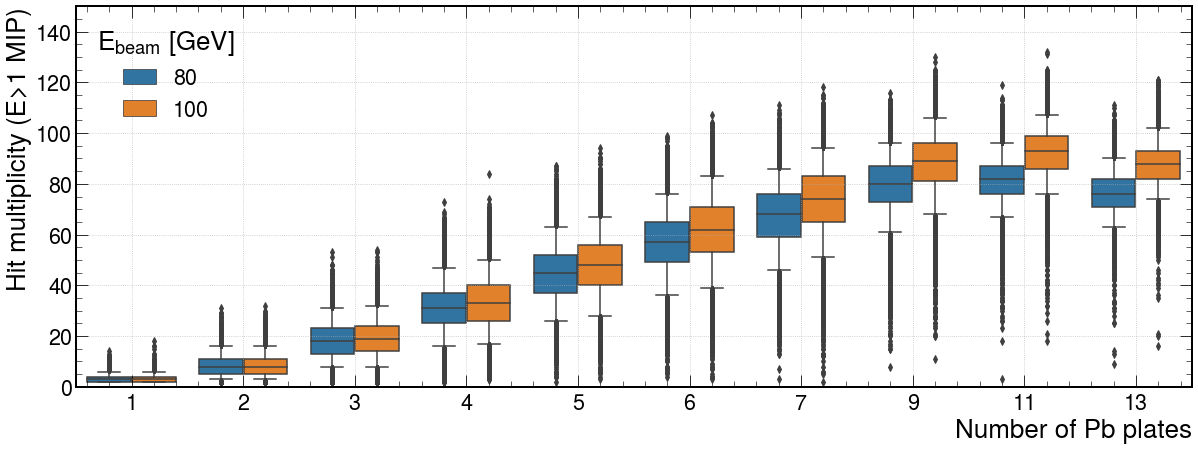

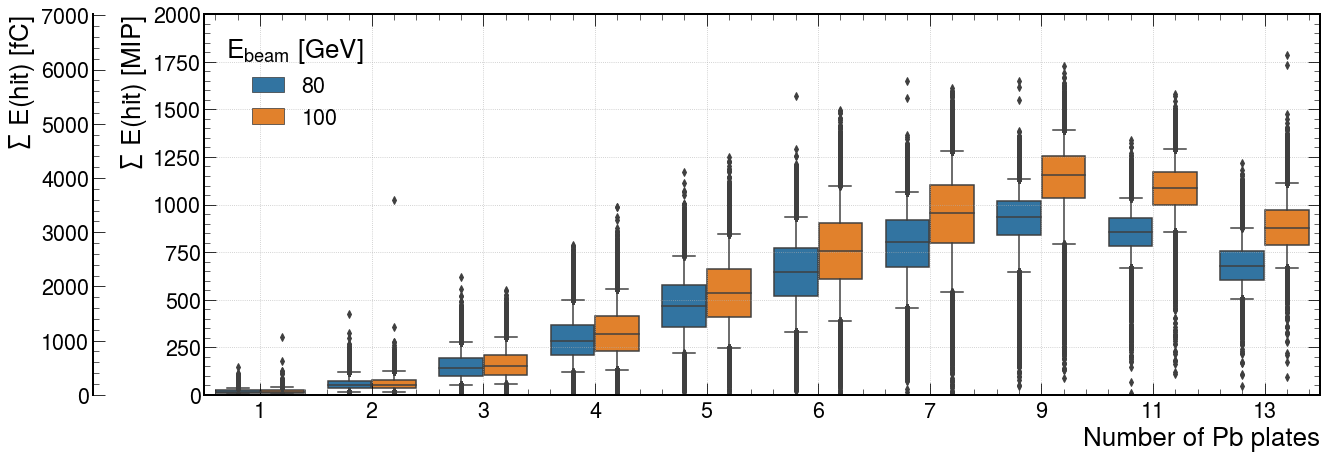

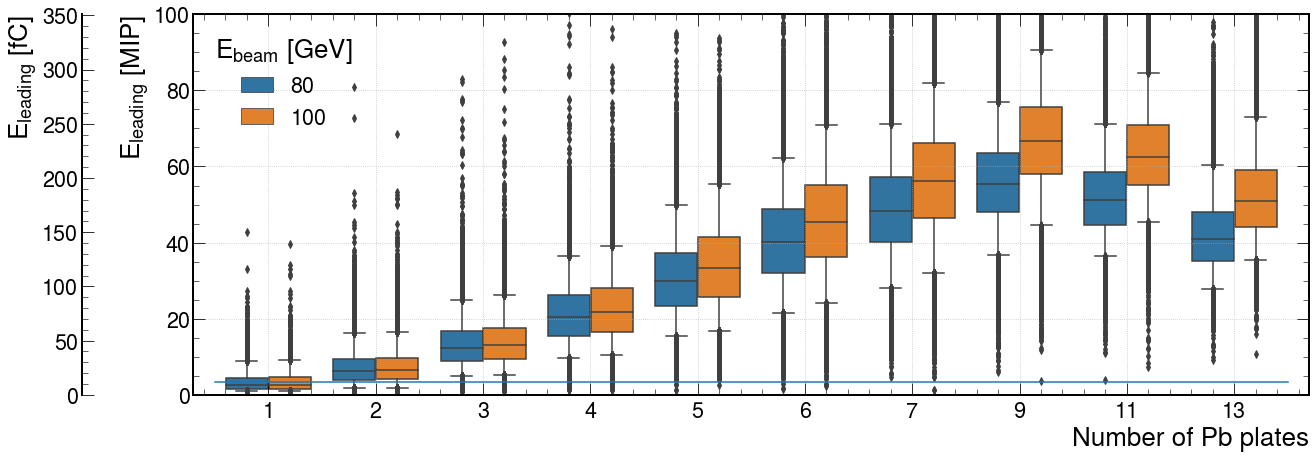

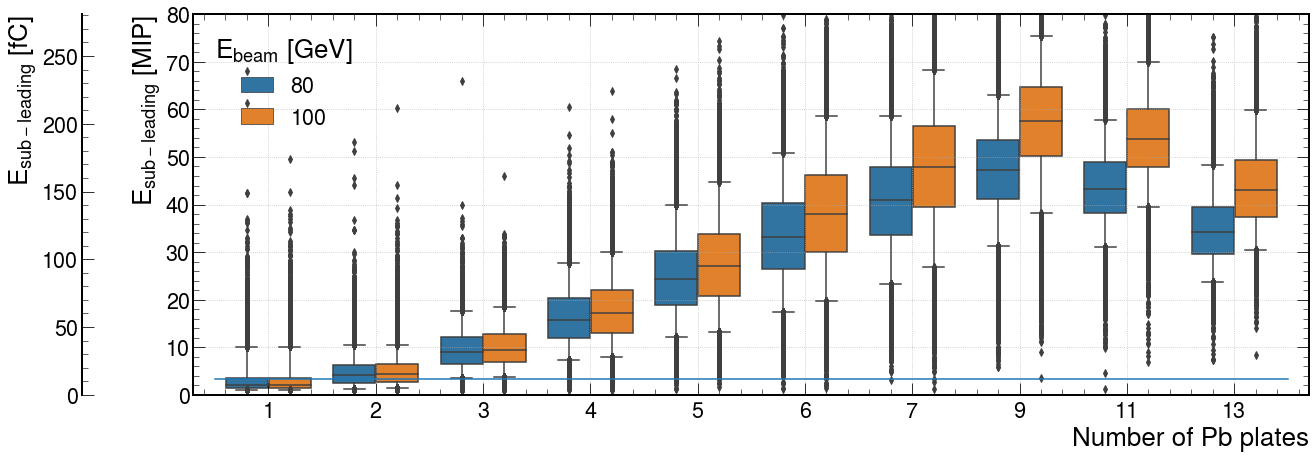

In [36]:
def mip2fc(x): return x*3.51
def fc2mip(x): return x/3.51

def showProfileFor(var='nhits1mip',title=r'Hit multiplicity (E>1 MIP)',ylim=(0,40)):

    #use only same Air thickness models
    data=df[df['model']<130]
    
    fig,ax=plt.subplots(1,1,figsize=(20,7))
    sns.boxplot(data=data, x="nplates", y=var, hue="genEn",ax=ax, whis=[5, 95])
    ax.grid()
    ax.set_xlabel(r'Number of Pb plates')
    ax.set_ylabel(title)
    if ylim: ax.set_ylim(*ylim)
    ax.legend(loc='upper left',title=r'$E_{beam}$ [GeV]')
        
    if 'en' in var:
        secay = ax.secondary_yaxis(-0.1, functions=(mip2fc,fc2mip))
        secay.set_ylabel(title.replace('MIP','fC'))
        if var.find('en')==0:
            ax.plot(ax.get_xlim(),fc2mip(np.array([12,12])))
                
    plt.savefig(f'{_plots_dir}/{var}_profile.png')
    plt.show()
    
showProfileFor('nhits1mip',r'Hit multiplicity (E>1 MIP)',(0,150))
showProfileFor('total_en', r'$\sum$ E(hit) [MIP]',(0,2000))
showProfileFor('en1', r'$E_{leading}$ [MIP]',(0,100))
showProfileFor('en2', r'$E_{sub-leading}$ [MIP]',(0,80))

In [37]:
def compareDistributions(genEn,models,hue='nplates',var='nhits1mip',title=r'Hit multiplicity (E>1 MIP)',bins='auto'):
    
    mask=(df['genEn']==genEn) & df['model'].isin(models)
    data=df[mask]
    
    fig,ax=plt.subplots(1,1,figsize=(8,8))
    sns.histplot(data=data, x=var, hue=hue, stat="density", common_norm=False, ax=ax,bins=bins)
    ax.grid()
    ax.set_xlabel(title)
    ax.set_ylabel('Density')
    ax.text(0.5,0.9,f'E={genEn} GeV',transform=ax.transAxes,ha='center')
    
    if 'en' in var:
        secax = ax.secondary_xaxis(-0.25, functions=(mip2fc,fc2mip))
        secax.set_xlabel(title.replace('MIP','fC'))
        if var.find('en')==0:
            ax.plot(fc2mip(np.array([12,12])),ax.get_ylim())
    
    plt.savefig(f'{_plots_dir}/{var}_genEn{genEn:3.0f}_dist.png')
    plt.show()

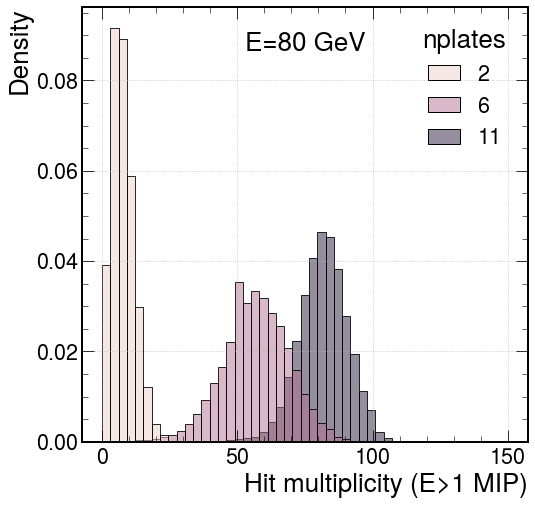

In [47]:
#compare different W thickness, same air volume
kwargs={'models':[121,125,128],
        'hue':'nplates',
        'genEn':80}
compareDistributions(var='nhits1mip', title=r'Hit multiplicity (E>1 MIP)', bins=np.linspace(0,150,50), **kwargs)
compareDistributions(var='total_en',  title=r'$\sum$ E(hit) [MIP]',        bins=np.linspace(0,1200,50), **kwargs)
compareDistributions(var='en1',       title=r'$E_{leading}$ [MIP]',        bins=np.linspace(0,100,50),   **kwargs)
compareDistributions(var='en2',       title=r'$E_{sub-leading}$ [MIP]',    bins=np.linspace(0,100,50),   **kwargs)

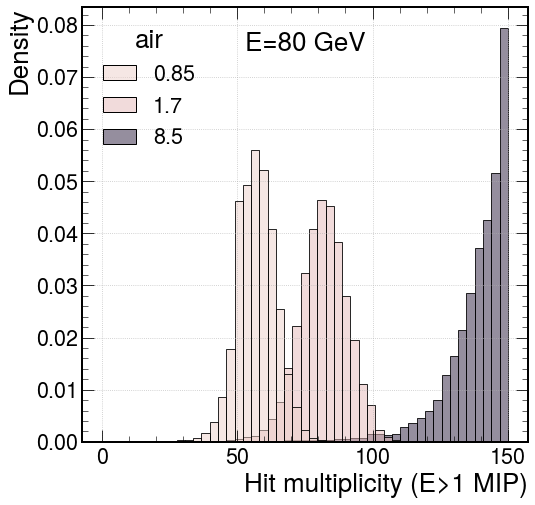

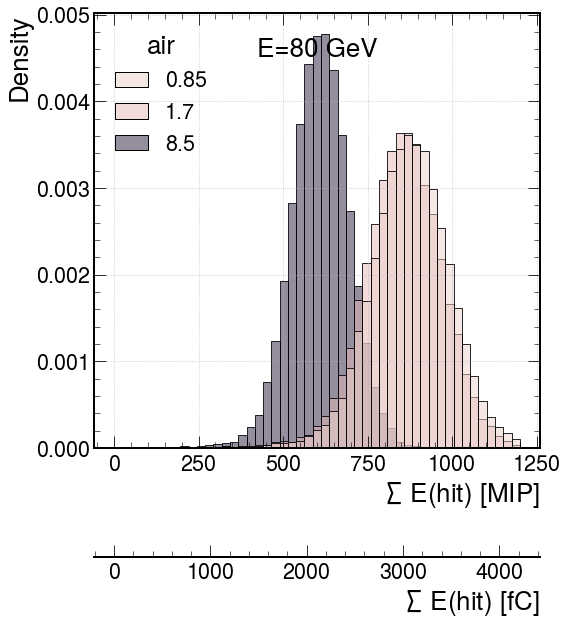

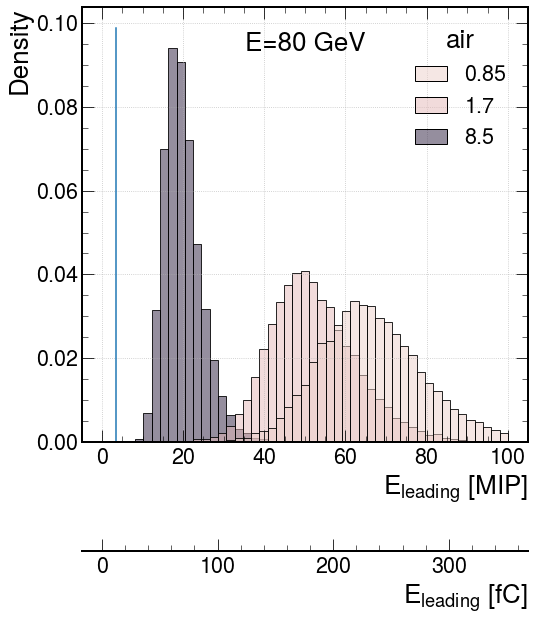

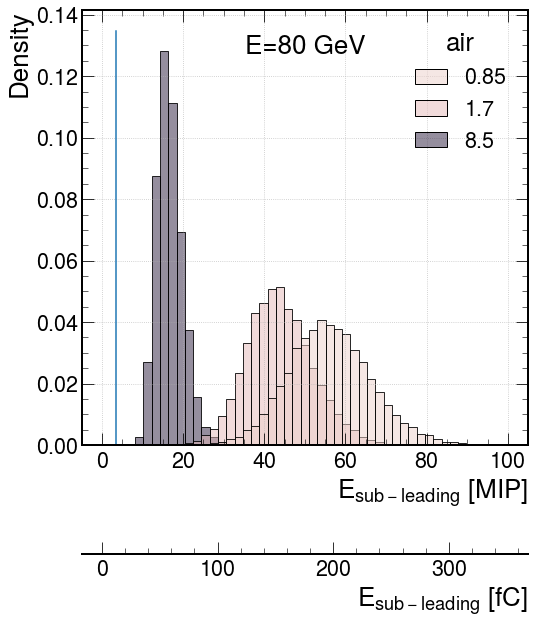

In [51]:
#compare different air volumes, for the same W
kwargs={'models':[130,128,132],
        'hue':'air',
        'genEn':80}
compareDistributions(var='nhits1mip', title=r'Hit multiplicity (E>1 MIP)', bins=np.linspace(0,150,50), **kwargs)
compareDistributions(var='total_en',  title=r'$\sum$ E(hit) [MIP]',        bins=np.linspace(0,1200,50), **kwargs)
compareDistributions(var='en1',       title=r'$E_{leading}$ [MIP]',        bins=np.linspace(0,100,50),   **kwargs)
compareDistributions(var='en2',       title=r'$E_{sub-leading}$ [MIP]',    bins=np.linspace(0,100,50),   **kwargs)

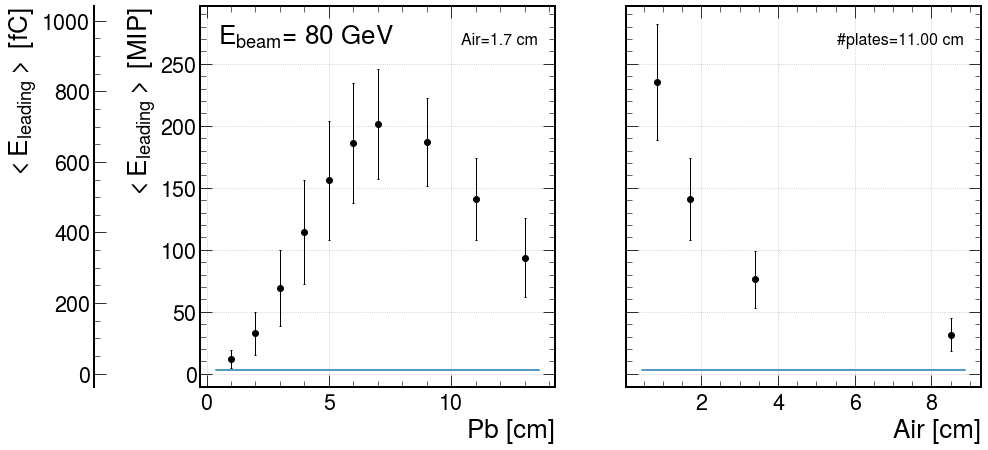

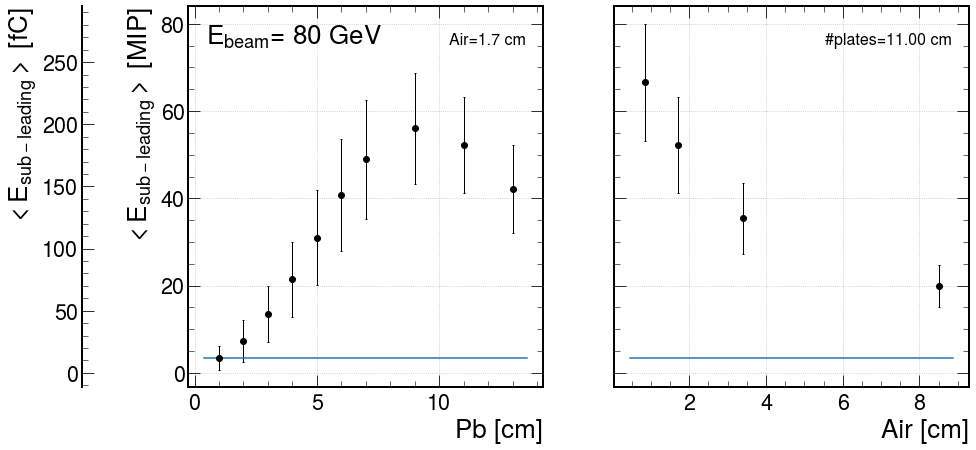

In [53]:
#make a profile of the behavior for the different models
metrics={'en0':['mean','std'],
         'en1':['mean','std'],
         'nplates':'mean',
         'air':'mean',
         }
agg=df.groupby(['genEn','model']).agg(metrics).reset_index()
agg.columns = [''.join(gp) for gp in agg.columns.values]


def drawProfile(var='en0',title=r'$<E_{leading}>$ [MIP]',genEn=80):

    #plot for a fixed energy
    ebar_style={'marker':'o','elinewidth':1,'capsize':1,'ls':'none','color':'k'}

    fig,ax=plt.subplots(1,2,figsize=(14,7),sharey=True)
    
    mask=(agg['genEn']==genEn) & (agg['model']<130)
    ax[0].errorbar(agg[mask]['nplatesmean'],agg[mask][f'{var}mean'],yerr=agg[mask][f'{var}std'],**ebar_style)
    ax[0].text(0.05,0.9,rf'$E_{{beam}}$={genEn:3.0f} GeV',transform=ax[0].transAxes)
    ax[0].text(0.95,0.9,rf'Air={baseair} cm',transform=ax[0].transAxes,ha='right',fontsize=16) 
    ax[0].set_xlabel('Pb [cm]')
    ax[0].set_ylabel(title)
    ax[0].grid()
    
    
    mask=(agg['genEn']==genEn) & (agg['model'].isin([130,128,131,132]))
    ax[1].errorbar(agg[mask]['airmean'],agg[mask][f'{var}mean'],yerr=agg[mask][f'{var}std'],**ebar_style)
    ax[1].text(0.95,0.9,f'#plates={_models_dict[128][0]:3.2f} cm',transform=ax[1].transAxes,ha='right',fontsize=16)
    ax[1].set_xlabel('Air [cm]')
    ax[1].grid()
    
    if 'en' in var:
        secax = ax[0].secondary_yaxis(-0.3, functions=(mip2fc,fc2mip))
        secax.set_ylabel(title.replace('MIP','fC'))
        ax[0].plot(ax[0].get_xlim(),fc2mip(np.array([12,12])))
        ax[1].plot(ax[1].get_xlim(),fc2mip(np.array([12,12])))
    
    plt.savefig(f'{_plots_dir}/profile_{var}_genEn{genEn:3.0f}_dist.png')
    plt.show()
                                
drawProfile(var='en0',title=r'$<E_{leading}>$ [MIP]',genEn=80)
drawProfile(var='en1',title=r'$<E_{sub-leading}>$ [MIP]',genEn=80)

## 3. Time difference

This is unrealistic, it's just to show the simulated time difference of two pads as an example

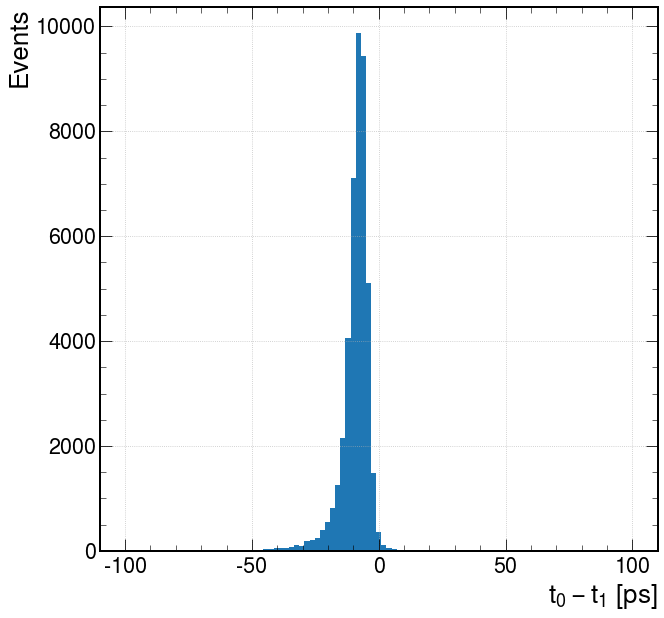

In [26]:
mask=(df['en0']>3) & (df['en1']>3) & (df['model']==128)
plt.hist(1e3*(df[mask]['t0']-df[mask]['t1']),np.linspace(-100,100,100))
plt.xlabel(r'$t_0-t_1$ [ps]')
plt.ylabel('Events')
plt.grid()
plt.show()